<a href="https://colab.research.google.com/github/parment1/CAS-Advanced-Data-Science-/blob/main/project_final_14_03_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CAS ADS M6
2022-03-14
Stefan Reinhard
Thomas Parmentier

In [1]:
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras import Model
from tensorflow.keras.layers import Input
from keras.layers import Dropout
from keras.initializers import he_normal, normal
from keras.callbacks import EarlyStopping
import seaborn as sns
import time
import platform
print (platform.machine())
print(f"TensorFlow has access to the following devices:\n{tf.config.list_physical_devices()}")
print(f"TensorFlow version: {tf.__version__}")

x86_64
TensorFlow has access to the following devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
TensorFlow version: 2.8.0


In [2]:
#setup data
x = []
y = []
with open('spambase.data', 'rt') as csvfile:
    data = csv.reader(csvfile, delimiter=',')
    for raw in data:
        x.append(np.array(raw[:-1], dtype=np.float32))
        y.append(int(raw[-1]))

X = np.array(x)
y = np.array(y)

#Importing columns names
colums=[]

with open('spambase.names',"r") as doc:
    lines=doc.readlines()
    for line in lines :
        colums.append(line.split(":")[0])
print(colums)

n_ch = X.shape[-1]
#normalize inputs
for ch in range(n_ch):
    ch_v = X[:, ch]
    norm = ch_v.max()
    X[:, ch] /= norm

print(X.shape, y.shape)
print(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1, stratify=y, shuffle=True)

['word_freq_make', 'word_freq_address', 'word_freq_all', 'word_freq_3d', 'word_freq_our', 'word_freq_over', 'word_freq_remove', 'word_freq_internet', 'word_freq_order', 'word_freq_mail', 'word_freq_receive', 'word_freq_will', 'word_freq_people', 'word_freq_report', 'word_freq_addresses', 'word_freq_free', 'word_freq_business', 'word_freq_email', 'word_freq_you', 'word_freq_credit', 'word_freq_your', 'word_freq_font', 'word_freq_000', 'word_freq_money', 'word_freq_hp', 'word_freq_hpl', 'word_freq_george', 'word_freq_650', 'word_freq_lab', 'word_freq_labs', 'word_freq_telnet', 'word_freq_857', 'word_freq_data', 'word_freq_415', 'word_freq_85', 'word_freq_technology', 'word_freq_1999', 'word_freq_parts', 'word_freq_pm', 'word_freq_direct', 'word_freq_cs', 'word_freq_meeting', 'word_freq_original', 'word_freq_project', 'word_freq_re', 'word_freq_edu', 'word_freq_table', 'word_freq_conference', 'char_freq_;', 'char_freq_(', 'char_freq_[', 'char_freq_!', 'char_freq_$', 'char_freq_#', 'capita

In [3]:
#Combined the data with labels, and check if there is any na / null

df_combined=pd.read_csv('spambase.data',names=colums)
df_describe = df_combined.describe().round(3)
print(df_combined.isna().any().any())
print(df_combined.isnull().any().any())
for col in df_combined.columns:
    print(col)

False
False
word_freq_make
word_freq_address
word_freq_all
word_freq_3d
word_freq_our
word_freq_over
word_freq_remove
word_freq_internet
word_freq_order
word_freq_mail
word_freq_receive
word_freq_will
word_freq_people
word_freq_report
word_freq_addresses
word_freq_free
word_freq_business
word_freq_email
word_freq_you
word_freq_credit
word_freq_your
word_freq_font
word_freq_000
word_freq_money
word_freq_hp
word_freq_hpl
word_freq_george
word_freq_650
word_freq_lab
word_freq_labs
word_freq_telnet
word_freq_857
word_freq_data
word_freq_415
word_freq_85
word_freq_technology
word_freq_1999
word_freq_parts
word_freq_pm
word_freq_direct
word_freq_cs
word_freq_meeting
word_freq_original
word_freq_project
word_freq_re
word_freq_edu
word_freq_table
word_freq_conference
char_freq_;
char_freq_(
char_freq_[
char_freq_!
char_freq_$
char_freq_#
capital_run_length_average
capital_run_length_longest
capital_run_length_total
class


In [4]:
#have much higher values (means = 52, 283 etc.) than most other columns which represent fraction of word occurrences (no. of times word appears in email/total no. of words in email)
df_combined.describe()

word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
count     4601.000000        4601.000000    4601.000000   4601.000000   
mean         0.104553           0.213015       0.280656      0.065425   
std          0.305358           1.290575       0.504143      1.395151   
min          0.000000           0.000000       0.000000      0.000000   
25%          0.000000           0.000000       0.000000      0.000000   
50%          0.000000           0.000000       0.000000      0.000000   
75%          0.000000           0.000000       0.420000      0.000000   
max          4.540000          14.280000       5.100000     42.810000   

       word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
count    4601.000000     4601.000000       4601.000000         4601.000000   
mean        0.312223        0.095901          0.114208            0.105295   
std         0.672513        0.273824          0.391441            0.401071   
min         0.000000        0.000000          0.000000            0.000000   
25%         0.000000        0.000000          0.000000            0.000000   
50%         0.000000        0.000000          0.000000            0.000000   
75%         0.380000        0.000000          0.000000            0.000000   
max        10.000000        5.880000          7.270000           11.110000   

       word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
count      4601.000000     4601.000000  ...  4601.000000  4601.000000   
mean          0.090067        0.239413  ...     0.038575     0.139030   
std           0.278616        0.644755  ...     0.243471     0.270355   
min           0.000000        0.000000  ...     0.000000     0.000000   
25%           0.000000        0.000000  ...     0.000000     0.000000   
50%           0.000000        0.000000  ...     0.000000     0.065000   
75%           0.000000        0.160000  ...     0.000000     0.188000   
max           5.260000       18.180000  ...     4.385000     9.752000   

       char_freq_[  char_freq_!  char_freq_$  char_freq_#  \
count  4601.000000  4601.000000  4601.000000  4601.000000   
mean      0.016976     0.269071     0.075811     0.044238   
std       0.109394     0.815672     0.245882     0.429342   
min       0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.315000     0.052000     0.000000   
max       4.081000    32.478000     6.003000    19.829000   

       capital_run_length_average  capital_run_length_longest  \
count                 4601.000000                 4601.000000   
mean                     5.191515                   52.172789   
std                     31.729449                  194.891310   
min                      1.000000                    1.000000   
25%                      1.588000                    6.000000   
50%                      2.276000                   15.000000   
75%                      3.706000                   43.000000   
max                   1102.500000                 9989.000000   

       capital_run_length_total        class  
count               4601.000000  4601.000000  
mean                 283.289285     0.394045  
std                  606.347851     0.488698  
min                    1.000000     0.000000  
25%                   35.000000     0.000000  
50%                   95.000000     0.000000  
75%                  266.000000     1.000000  
max                15841.000000     1.000000  

[8 rows x 58 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


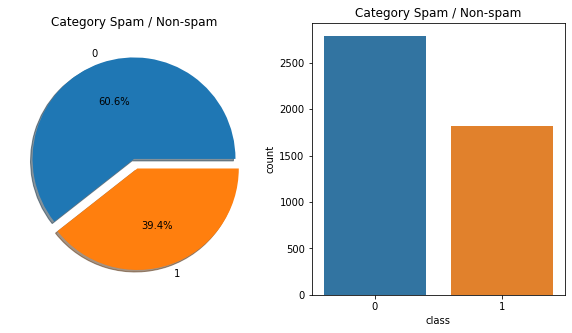

In [5]:
#To show the distribution of spam data
f,ax=plt.subplots(1,2,figsize=(10,5))
df_combined['class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Category Spam / Non-spam')
ax[0].set_ylabel('')
sns.countplot('class',data=df_combined,ax=ax[1])
ax[1].set_title('Category Spam / Non-spam')
plt.show()

[Text(0, 0.5, 'average frequency'),
 Text(0.5, 1.0, 'Non Spam minus Spam average word and char frequency')]

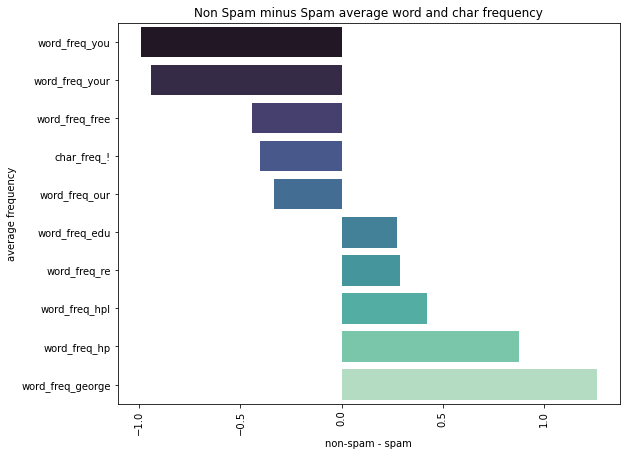

In [6]:
#chart showing the words that are the most frequent in a spam vs. the one less frenquent.
#E.g. in spams we have a lot of chars and numbers
pivot_class_freq=pd.pivot_table(df_combined,values=df_combined.drop(["class","capital_run_length_average","capital_run_length_longest","capital_run_length_total"],axis=1),index='class',aggfunc="mean")
pivot_class_freq.loc['non-spam - spam'] = pivot_class_freq.loc[0] - pivot_class_freq.loc[1]
pivot_class_freq_transposed = pivot_class_freq.T.reset_index()
pivot_class_freq_transposed.head(5)

nlargest = pivot_class_freq_transposed.nlargest(5, 'non-spam - spam')
nsmallest = pivot_class_freq_transposed.nsmallest(5, 'non-spam - spam')
df = pd.concat([nsmallest, nlargest], axis=0)
df = df.sort_values(by='non-spam - spam')

sns.color_palette("mako", as_cmap=True)
plt.figure(figsize=(9,7))
plt.xticks(rotation=90)
sns.barplot(x=df['non-spam - spam'],
            y=df['index'],
            palette="mako").set(title="Non Spam minus Spam average word and char frequency",ylabel="average frequency")

# 1 Random model

Model: "Sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 32)                1856      
                                                                 
 Layer2 (Dense)              (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


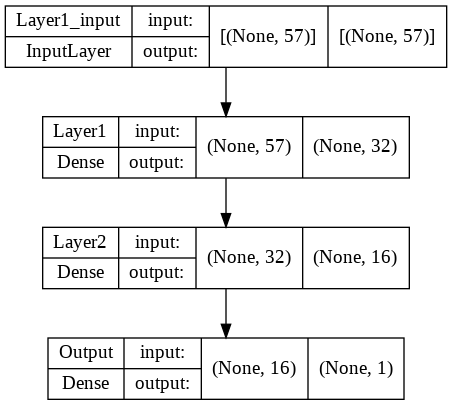

In [12]:
model = Sequential(name='Sequential_model')
model.add(Dense(32,activation='relu',name='Layer1', input_shape=(X.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu',name='Layer2'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid',name='Output'))
model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

Epoch 1/20
115/115 [==============================] - 1s 4ms/step - loss: 0.2665 - accuracy: 0.9008 - val_loss: 0.2009 - val_accuracy: 0.9349
Epoch 2/20
115/115 [==============================] - 0s 2ms/step - loss: 0.2028 - accuracy: 0.9280 - val_loss: 0.2365 - val_accuracy: 0.9110
Epoch 3/20
115/115 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.9345 - val_loss: 0.2028 - val_accuracy: 0.9229
Epoch 4/20
115/115 [==============================] - 0s 2ms/step - loss: 0.1803 - accuracy: 0.9334 - val_loss: 0.1997 - val_accuracy: 0.9305
Epoch 5/20
115/115 [==============================] - 0s 2ms/step - loss: 0.1668 - accuracy: 0.9389 - val_loss: 0.1786 - val_accuracy: 0.9349
Epoch 6/20
115/115 [==============================] - 0s 3ms/step - loss: 0.1559 - accuracy: 0.9432 - val_loss: 0.1936 - val_accuracy: 0.9294
Epoch 7/20
115/115 [==============================] - 0s 2ms/step - loss: 0.1507 - accuracy: 0.9432 - val_loss: 0.2008 - val_accuracy: 0.9338
Epoch 

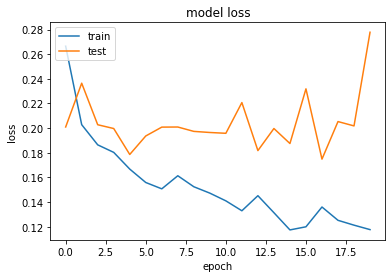

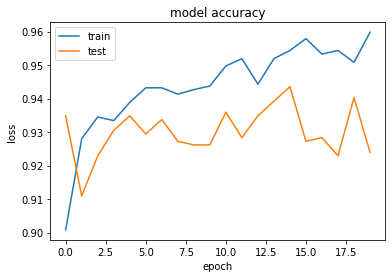

CPU times: user 8.13 s, sys: 512 ms, total: 8.65 s
Wall time: 12.1 s


In [13]:
%%time
ed = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('Val_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test),callbacks=[ed, mc])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 57)]              0         
                                                                 
 Layer1 (Dense)              (None, 32)                1856      
                                                                 
 Layer2 (Dense)              (None, 16)                528       
                                                                 
 Output (Dense)              (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
115/115 [==============================] - 2s 7ms/step - loss: 0.2783 - accuracy: 0.8954 - val_loss: 0.2446 - val_accuracy: 0.9186
Epoch 2/20
115/115 [===========================

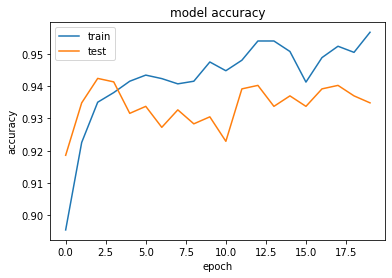

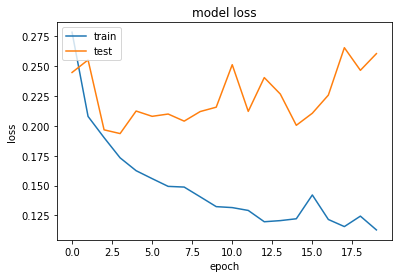

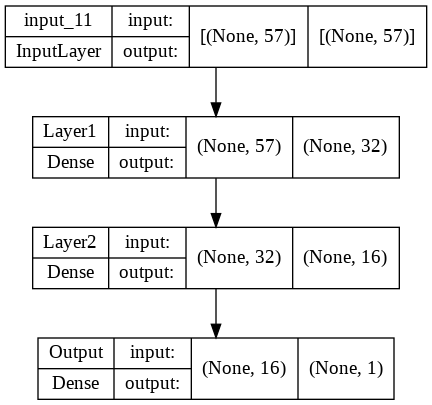

In [ ]:
#functional classifier

def classifier_functional(X, M):
    N = X.shape[1]
    layer1 = Input(shape = (N, ))
    layer2 = Dense(M, activation='relu', name='Layer1')(layer1)
    layer3 = Dense(M/2, activation='relu', name='Layer2')(layer2)
    output = Dense(1, activation='sigmoid', name='Output')(layer3)
    func_model = Model(inputs =layer1, outputs=output)   
    func_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.1), metrics=['accuracy'])
    func_model.summary()
    return func_model

def Plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

M = 32
model = classifier_functional(x, M)
history = model.fit(X_train, y_train, epochs= 20, verbose=1, shuffle = False,validation_data=(X_test, y_test)) 
Plot(history)
tf.keras.utils.plot_model(model, show_shapes=True)

# 2 Grid search hyperparameter

## 2.1 Batch size and epochs
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

In [ ]:
%%time
# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.1), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
batch_size = [16,32,64,128]
epochs = [10,20, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, validation_data=(X_test, y_test))
grid_result1 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # This is added back by InteractiveShellApp.init_path()


Best: 0.936685 using {'batch_size': 32, 'epochs': 100}
0.930975 (0.007829) with: {'batch_size': 16, 'epochs': 10}
0.931794 (0.000756) with: {'batch_size': 16, 'epochs': 20}
0.932609 (0.004009) with: {'batch_size': 16, 'epochs': 50}
0.929619 (0.003372) with: {'batch_size': 16, 'epochs': 100}
0.920381 (0.013009) with: {'batch_size': 32, 'epochs': 10}
0.927992 (0.010147) with: {'batch_size': 32, 'epochs': 20}
0.930978 (0.003294) with: {'batch_size': 32, 'epochs': 50}
0.936685 (0.000397) with: {'batch_size': 32, 'epochs': 100}
0.933152 (0.001331) with: {'batch_size': 64, 'epochs': 10}
0.930705 (0.005051) with: {'batch_size': 64, 'epochs': 20}
0.928531 (0.003103) with: {'batch_size': 64, 'epochs': 50}
0.927175 (0.008041) with: {'batch_size': 64, 'epochs': 100}
0.922552 (0.006017) with: {'batch_size': 128, 'epochs': 10}
0.930705 (0.005227) with: {'batch_size': 128, 'epochs': 20}
0.932065 (0.001404) with: {'batch_size': 128, 'epochs': 50}
0.932609 (0.003128) with: {'batch_size': 128, 'epochs'

## 2.2  Optimizer

In [ ]:
%%time
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
optimizer = ['SGD', 'Adam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
grid_result2 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  if __name__ == '__main__':


Best: 0.929076 using {'optimizer': 'Adam'}
0.607339 (0.007199) with: {'optimizer': 'SGD'}
0.929076 (0.001770) with: {'optimizer': 'Adam'}
CPU times: user 4.2 s, sys: 242 ms, total: 4.44 s
Wall time: 20.4 s


 ## 2.3 Learning Rate



In [ ]:
%%time
def create_model(learn_rate=0.01):
    # create model
    model = Sequential()
    model.add(Dense(8,activation='relu', input_shape=(X.shape[1],)))
    model.add(Dense(16,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learn_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=0)
# define the grid search parameters
learn_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learn_rate=learn_rate)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train,epochs=20, batch_size=64, validation_data=(X_test, y_test))
grid_result3 = grid_result
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  # Remove the CWD from sys.path while we load stuff.


Best: 0.931249 using {'learn_rate': 0.01}
0.730687 (0.070791) with: {'learn_rate': 0.0001}
0.925815 (0.002421) with: {'learn_rate': 0.001}
0.931249 (0.004355) with: {'learn_rate': 0.01}
0.928530 (0.008687) with: {'learn_rate': 0.1}
0.917938 (0.015166) with: {'learn_rate': 0.2}
0.927175 (0.005566) with: {'learn_rate': 0.3}
CPU times: user 4.1 s, sys: 259 ms, total: 4.36 s
Wall time: 50.8 s


In [ ]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))

Best: 0.936685 using {'batch_size': 32, 'epochs': 100}
Best: 0.929076 using {'optimizer': 'Adam'}
Best: 0.931249 using {'learn_rate': 0.01}


## 2.4 Tuned model

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 32)                1856      
                                                                 
 dense_29 (Dense)            (None, 16)                528       
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


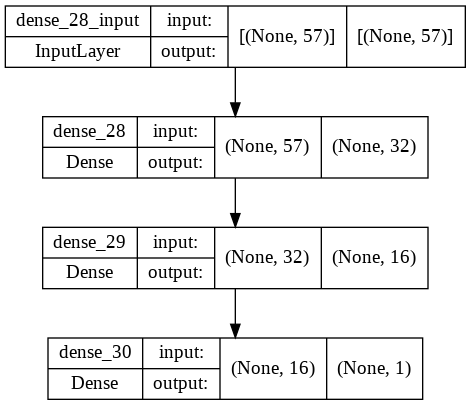

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

Epoch 1/20
58/58 [==============================] - 1s 5ms/step - loss: 0.6424 - accuracy: 0.6084 - val_loss: 0.5814 - val_accuracy: 0.6417
Epoch 2/20
58/58 [==============================] - 0s 3ms/step - loss: 0.5053 - accuracy: 0.7679 - val_loss: 0.4180 - val_accuracy: 0.8578
Epoch 3/20
58/58 [==============================] - 0s 3ms/step - loss: 0.3697 - accuracy: 0.8761 - val_loss: 0.3133 - val_accuracy: 0.9088
Epoch 4/20
58/58 [==============================] - 0s 3ms/step - loss: 0.2948 - accuracy: 0.9019 - val_loss: 0.2634 - val_accuracy: 0.9186
Epoch 5/20
58/58 [==============================] - 0s 3ms/step - loss: 0.2576 - accuracy: 0.9109 - val_loss: 0.2368 - val_accuracy: 0.9283
Epoch 6/20
58/58 [==============================] - 0s 3ms/step - loss: 0.2351 - accuracy: 0.9166 - val_loss: 0.2217 - val_accuracy: 0.9381
Epoch 7/20
58/58 [==============================] - 0s 3ms/step - loss: 0.2200 - accuracy: 0.9223 - val_loss: 0.2132 - val_accuracy: 0.9327
Epoch 8/20
58/58 [==

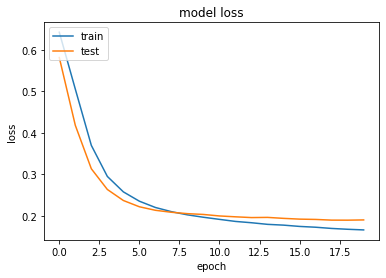

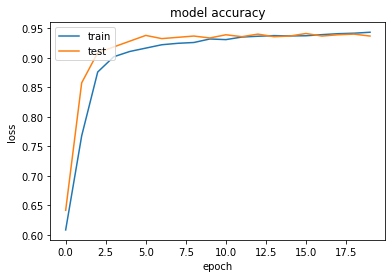

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 3 random parameter

## 3.1 add complexity

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               7424      
                                                                 
 dense_16 (Dense)            (None, 32)                4128      
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,097
Trainable params: 12,097
Non-trainable params: 0
_________________________________________________________________


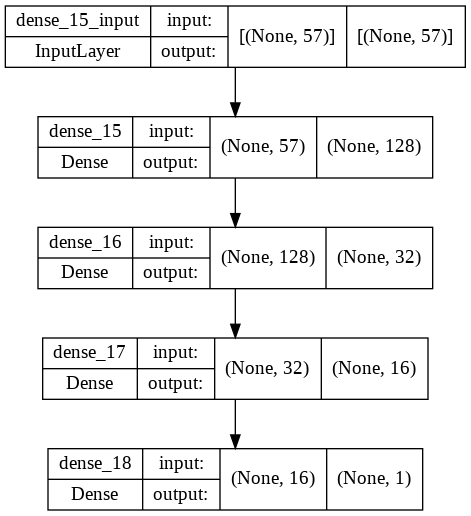

In [ ]:
model = Sequential()
model.add(Dense(128,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

Epoch 1/20
58/58 [==============================] - 1s 6ms/step - loss: 0.5821 - accuracy: 0.7087 - val_loss: 0.4072 - val_accuracy: 0.8708
Epoch 2/20
58/58 [==============================] - 0s 4ms/step - loss: 0.3124 - accuracy: 0.8959 - val_loss: 0.2474 - val_accuracy: 0.9262
Epoch 3/20
58/58 [==============================] - 0s 3ms/step - loss: 0.2292 - accuracy: 0.9198 - val_loss: 0.2098 - val_accuracy: 0.9338
Epoch 4/20
58/58 [==============================] - 0s 4ms/step - loss: 0.1984 - accuracy: 0.9304 - val_loss: 0.1977 - val_accuracy: 0.9370
Epoch 5/20
58/58 [==============================] - 0s 4ms/step - loss: 0.1858 - accuracy: 0.9364 - val_loss: 0.1957 - val_accuracy: 0.9283
Epoch 6/20
58/58 [==============================] - 0s 4ms/step - loss: 0.1784 - accuracy: 0.9364 - val_loss: 0.1961 - val_accuracy: 0.9370
Epoch 7/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1711 - accuracy: 0.9380 - val_loss: 0.1882 - val_accuracy: 0.9414
Epoch 8/20
58/58 [==

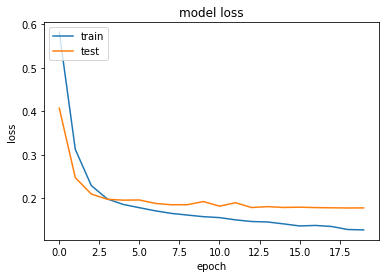

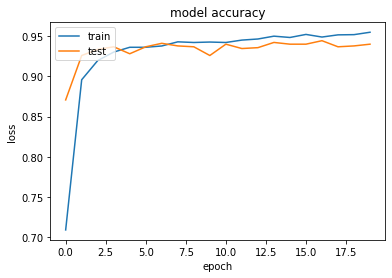

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                1856      
                                                                 
 dense_20 (Dense)            (None, 16)                528       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


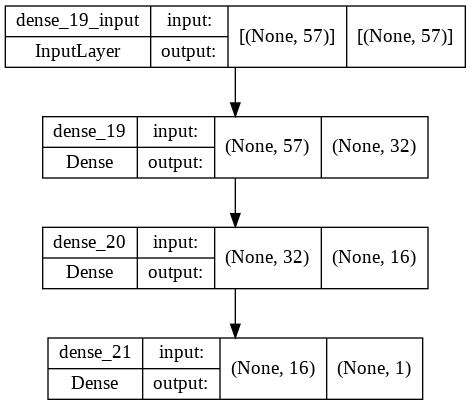

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

Epoch 1/20
58/58 [==============================] - 1s 5ms/step - loss: 0.3217 - accuracy: 0.8660 - val_loss: 0.2109 - val_accuracy: 0.9294
Epoch 2/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1908 - accuracy: 0.9291 - val_loss: 0.1978 - val_accuracy: 0.9370
Epoch 3/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1916 - accuracy: 0.9332 - val_loss: 0.1961 - val_accuracy: 0.9294
Epoch 4/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9359 - val_loss: 0.1960 - val_accuracy: 0.9283
Epoch 5/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1611 - accuracy: 0.9405 - val_loss: 0.1814 - val_accuracy: 0.9370
Epoch 6/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1592 - accuracy: 0.9402 - val_loss: 0.1756 - val_accuracy: 0.9370
Epoch 7/20
58/58 [==============================] - 0s 3ms/step - loss: 0.1483 - accuracy: 0.9495 - val_loss: 0.1719 - val_accuracy: 0.9359
Epoch 8/20
58/58 [==

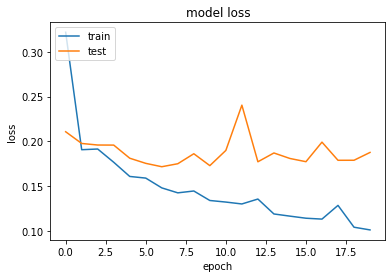

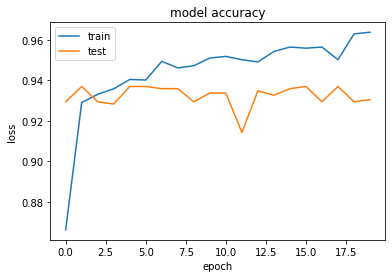

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3.3 increase epocs

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 32)                1856      
                                                                 
 dense_23 (Dense)            (None, 16)                528       
                                                                 
 dense_24 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/60
58/58 [==============================] - 1s 6ms/step - loss: 0.6587 - accuracy: 0.6712 - val_loss: 0.6091 - val_accuracy: 0.7742
Epoch 2/60
58/58 [==============================] - 0s 3ms/step - loss: 0.5285 - accuracy: 0.8342 - val_loss: 0.4253 - val_accuracy: 0.8697
Epoch 3/60
58/58 [==================

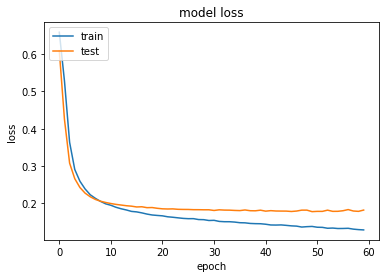

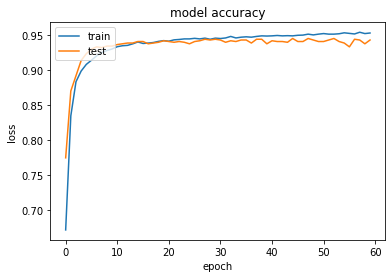

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3.4 decrease batch size

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                1856      
                                                                 
 dense_26 (Dense)            (None, 16)                528       
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
460/460 [==============================] - 2s 3ms/step - loss: 0.4249 - accuracy: 0.8527 - val_loss: 0.2585 - val_accuracy: 0.9207
Epoch 2/20
460/460 [==============================] - 1s 2ms/step - loss: 0.2343 - accuracy: 0.9168 - val_loss: 0.2119 - val_accuracy: 0.9392
Epoch 3/20
460/460 [============

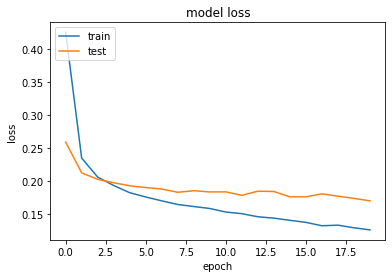

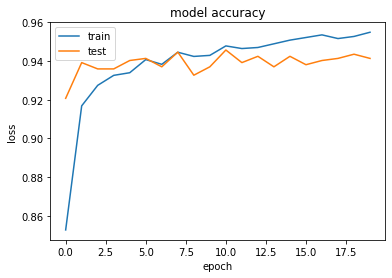

In [ ]:
model = Sequential()
model.add(Dense(32,activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(16,activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
utils.plot_model(model, show_shapes=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()